# Base PIP install

In [ ]:
!pip install japanize_matplotlib
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import japanize_matplotlib
import random



import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

from scipy.integrate import solve_ivp

# Setting Parameter(パラメータ設定)

In [ ]:
# パラメータ設定
m = 1.0       # 質量 [kg]
k = 10.0      # バネ定数 [N/m]
c = 1.0       # 減衰係数 [Ns/m]
l = 1.0       # 自然長 [m]
r0 = 1.0      # 初期位置 [m]
v_r0 = 0.0    # 初速度 [m/s]
v_theta0 = 5.0 # 初角速度 [rad/s]
t_end = 10    # シミュレーション時間 [s]
dt = 0.02     # タイムステップ [s]
t_step = int(t_end/dt)



# 初期条件
r = r0
theta = 0.0
h = r0**2 * v_theta0  # 角運動量保存則

In [ ]:
n_input = 1       # 入力層のノード数
n_output = 2      # 出力層のノード数
n_neuron = 50     # 中間層のニューロン数
n_layer = 3       # 中間層の層数
epochs = 100000        # 計算エポック数
act_fn = nn.Tanh()
learning_rate = 1e-3
physic_loss_weight = 5e-5

# Implement Analytical (解析解)

In [ ]:
def analytic(m,k,c,l,r0,v_r0,v_thete0, t_end,dt,r,theta,h):
    # 配列を用意
    time = np.arange(0, t_end, dt)
    r_values = []
    theta_values = []

    # シミュレーション
    for t in time:
        # 運動方程式の計算
        r_dot = v_r0
        theta_dot = h / r**2
        r_ddot = -k/m * (r - l) - c/m * r_dot + h**2 / r**3

        # 数値積分 (Euler法)
        v_r0 += r_ddot * dt
        r += r_dot * dt
        theta += theta_dot * dt

        # 値を記録
        r_values.append(r)
        theta_values.append(theta)

    # 極座標をデカルト座標に変換
    x_values = [r * np.cos(theta) for r, theta in zip(r_values, theta_values)]
    y_values = [r * np.sin(theta) for r, theta in zip(r_values, theta_values)]

    return time, x_values, y_values




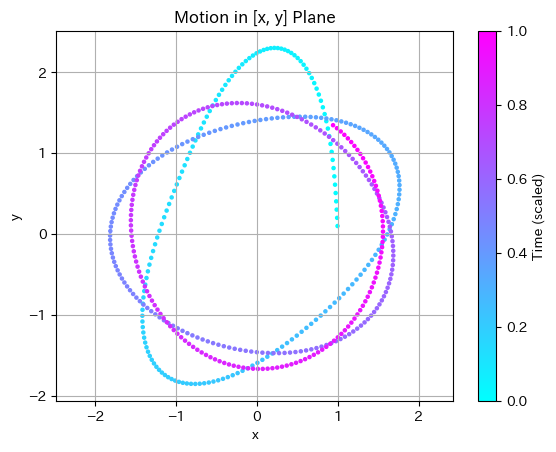

In [ ]:
time, x_values, y_values = analytic(m,k,c,l,r0,v_r0,v_theta0, t_end,dt,r,theta,h)

x_analytic = np.array(x_values)
y_analytic = np.array(y_values)

# カラーマップの作成
colors = np.linspace(0, 1, len(time))  # 時間によって色を変化
cmap = plt.get_cmap('cool')

# プロット
plt.scatter(x_values, y_values, c=colors, cmap=cmap, s=5)
plt.colorbar(label='Time (scaled)')
plt.title('Motion in [x, y] Plane')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.axis('equal')
plt.show()

# Implement PINNs class (PINNsクラスの実装)

In [ ]:
class NN(nn.Module):

    def __init__(self, n_input, n_output, n_neuron, n_layer, act_fn):

        super(NN, self).__init__()

        self.n_input = n_input
        self.n_output = n_output
        self.n_neuron = n_neuron
        self.n_layer = n_layer

        #set activation function
        self.activation = act_fn

        layers = []
        layers.append(nn.Linear(self.n_input, self.n_neuron))
        layers.append(self.activation)

        for _ in range(self.n_layer -1):
            layers.append(nn.Linear(self.n_neuron, self.n_neuron))
            layers.append(self.activation)
        layers.append(nn.Linear(self.n_neuron, self.n_output))
        self.layers = nn.Sequential(*layers)

        '''self.affine2 = nn.Linear(50, 50)
        self.affine3 = nn.Linear(50, 50)
        self.affine4 = nn.Linear(50, self.n_output)'''


    def forward(self, t):
        out = self.layers(t)
        return out[:,0], out[:,1]



In [ ]:
class PINNs():
    def __init__(self,
                 n_input,       # 入力層のノード数
                 n_output,      # 出力層のノード数
                 n_neuron,      # 中間層のニューロン数
                 n_layer,       # 中間層の層数
                 act_fn,        # 活性化関数
                 t,             # 教師データ(時間)
                 t_pinn,        # 定義時間域
                 x,             # 教師データ
                 y,
                 c,             # 減衰係数
                 k,             # バネ定数
                 epochs,        # 計算エポック数
                 lr = 1e-3
                 ):

        super(PINNs, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_neuron = n_neuron
        self.n_layer = n_layer
        self.act_fn = act_fn
        self.t = torch.tensor(t, requires_grad=True).float()
        self.t_pinn = torch.tensor(t_pinn, requires_grad=True).float()
        self.x_data = torch.tensor(x, requires_grad=True).float()
        self.y_data = torch.tensor(y, requires_grad=True).float()
        self.c = c
        self.k = k
        self.epochs = epochs
        self.lr = lr
        self.loss_fn = nn.MSELoss()


        #DEfine NN
        self.dnn = NN(
            self.n_input,
            self.n_output,
            self.n_neuron,
            self.n_layer,
            self.act_fn
        )

        #optimizers
        self.optimizer = torch.optim.Adam(self.dnn.parameters(), self.lr)

    def physic_loss(self,x_pred, y_pred,t):

        # デカルト座標から極座標へ変換
        r_pred = torch.sqrt(x_pred**2 + y_pred**2)
        theta_pred = torch.atan2(y_pred, x_pred)

        # 自動微分を使用して時間微分を計算
        dr_dt = torch.autograd.grad(r_pred, t, grad_outputs=torch.ones_like(r_pred), create_graph=True)[0]
        dr_dtdt = torch.autograd.grad(dr_dt, t, grad_outputs=torch.ones_like(dr_dt), create_graph=True)[0]
        dtheta_dt = torch.autograd.grad(theta_pred, t, grad_outputs=torch.ones_like(theta_pred), create_graph=True)[0]


        # 半径方向の運動方程式の誤差
        radial_eq = dr_dtdt + (k/m) * (r - l) + (c/m) * dr_dt - h**2 / r**3

        # 角運動量保存則の誤差
        angular_eq = dtheta_dt - h / r**2
        # 物理損失の合計
        radial_loss = torch.mean(radial_eq**2)
        angular_loss = torch.mean(angular_eq**2)

        phys_loss = radial_loss + angular_loss
        return phys_loss

    def loss_func(self,plw = 5e-4):
        self.optimizer.zero_grad()

        self.plw = plw

        x_pred,y_pred = self.dnn.forward(self.t)
        loss_x = self.loss_fn(x_pred, self.x_data)

        x_pred_pinn,y_pred_pinn = self.dnn.forward(self.t_pinn)


        loss_f = self.physic_loss(x_pred_pinn, y_pred_pinn, self.t_pinn)
        loss = loss_x + loss_f*self.plw

        return loss, loss_x, loss_f

        '''f_pred = self.net_f(self.t_region)
        loss_x = torch.mean((self.x - x_pred)**2)
        loss_f = torch.mean(f_pred**2)

        loss = loss_x + loss_f*self.plw

        return loss, loss_x, loss_f'''

    def train(self):
        t_list = []
        x_list = []
        f_list = []

        for epoch in tqdm(range(self.epochs), desc="Training Progress"):

            self.dnn.train()

            self.optimizer.zero_grad()
            self.loss, self.loss_x, self.loss_f = self.loss_func()
            self.loss.backward()
            self.optimizer.step()


            t_list.append(self.loss.item())
            x_list.append(self.loss_x.item())
            f_list.append(self.loss_f.item())

            '''if epoch % 100 ==0:
                print( 'Iter %d, Loss: %.5e, Loss_x: %.5e, Loss_f: %.5e' % (epoch, self.loss.item(), self.loss_x.item(), self.loss_f.item()))'''
        return t_list, x_list, f_list

    def predict(self, t):
        t = torch.tensor(t, requires_grad=True).float()

        self.dnn.eval()
        x, y = self.dnn(t)
        f = self.physic_loss(x,y,t)

        return x, y, f

# train

In [ ]:
#モデルの定義域を分割(学習最中のモデルの支配方程式当てはまり度を算出する際に使用する)
t_pinn = np.linspace(0, t_end, t_step)
# ベクトル化
t_pinn = t_pinn.reshape(-1, 1)

#t_pinnのうちが学習に使用するデータを５点抽出
random_list = [0, 5, 10, 20, 30, 45, 60, 75, 90]


t_data = t_pinn[random_list]
x_data = x_analytic[random_list]
y_data = y_analytic[random_list]

#インスタンス化
pinns = PINNs(
    n_input,
    n_output,
    n_neuron,
    n_layer,
    act_fn,
    t_data,
    t_pinn,
    x_data,
    y_data,
    c,
    k,
    epochs,
    learning_rate
    )

pinns.lr = learning_rate
pinns.plw = physic_loss_weight
pinns.epochs = 100000

#学習
train_loss, x_loss , f_loss= pinns.train()

Training Progress: 100%|██████████| 100000/100000 [21:49<00:00, 76.37it/s]


In [ ]:
time, x_values, y_values = analytic(m,k,c,l,r0,v_r0,v_theta0, t_end,dt,r,theta,h)

x_analytic = np.array(x_values)
y_analytic = np.array(y_values)

#予測
x_pred, y_pred, f_pred = pinns.predict(t_pinn)
x_pred = x_pred.detach().numpy()
y_pred = y_pred.detach().numpy()
# カラーマップの正規化
norm = plt.Normalize(t_pinn.min(), t_pinn.max())

'''# 予測値を線でプロット（色を時間で変化）
points = np.array([x_pred, y_pred]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap='viridis', norm=norm)

# Change here: Flatten t_pinn to a 1D array
lc.set_array(t_pinn.flatten())  # Use flatten() to convert to 1D

lc.set_linewidth(3)
plt.gca().add_collection(lc)
plt.colorbar(lc, label='Time')'''

plt.scatter(x_pred, y_pred, c = time, s=10, label='PINNs')

# 解析解を散布図でプロット（色を時間で変化）
plt.scatter(x_analytic, y_analytic, c=time, cmap='cool', s=5, label='Analytic')

plt.scatter(x_data, y_data, c='blue', s=10, label = 'sample')

# 学習データがある場合（x_dataとy_dataを使用）
# plt.scatter(x_data, y_data, s=100, label='Train')

# 軸の設定
'''plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)'''
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

NameError: name 'analytic' is not defined

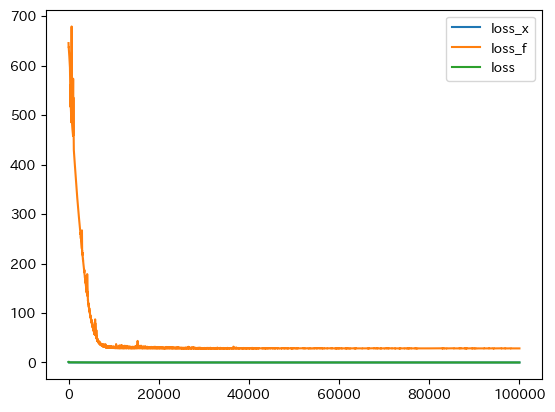

In [ ]:

plt.plot(x_loss, label='loss_x')
plt.plot(f_loss, label='loss_f')
plt.plot(train_loss, label='loss')
plt.legend()
plt.show()